In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


from sklearn.preprocessing import LabelEncoder


from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.metrics import  mean_squared_error, roc_auc_score,accuracy_score
from sklearn.ensemble import GradientBoostingRegressor,GradientBoostingClassifier

from pylab import rcParams

rcParams['figure.figsize'] = 10, 10
color = sns.color_palette()

In [4]:
train_df = pd.read_csv("input/train.csv")
test_df = pd.read_csv("input/test.csv")

id_test = test_df.id

#sprawdzam ile rekordow i atrybutow
print('train_df shape:',train_df.shape)
print('test_df shape:',test_df.shape)

train_df shape: (30471, 292)
test_df shape: (7662, 291)


In [5]:
dtype_df = train_df.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
print('Variables data type:')
dtype_df.groupby("Column Type").aggregate('count').reset_index()

Variables data type:


,Column Type,Count
0,int64,157
1,float64,119
2,object,16


In [6]:
print(train_df.loc[train_df['build_year'] == 20052009].id)
print(train_df.loc[train_df['state'] == 33].id)
print('build_year:',train_df.ix[10090].build_year)
print('state:',train_df.ix[10090].state)

train_df.loc[train_df['id'] == 10092, 'build_year'] = 2007
train_df.loc[train_df['id'] == 10092, 'state'] = 3
train_df.loc[train_df['id'] == 10093, 'build_year'] = 2009

10089    10092
Name: id, dtype: int64
10089    10092
Name: id, dtype: int64
build_year: nan
state: 1.0


In [7]:
for f in train_df.columns:
    if train_df[f].dtype=='object':
        lbl = LabelEncoder()
        lbl.fit(list(train_df[f].values)) 
        train_df[f] = lbl.transform(list(train_df[f].values))
        
for c in test_df.columns:
    if test_df[c].dtype == 'object':
        lbl = LabelEncoder()
        lbl.fit(list(test_df[c].values)) 
        test_df[c] = lbl.transform(list(test_df[c].values))

In [9]:
kitch_ratio = train_df['full_sq']/train_df['kitch_sq']
train_df['kitch_sq']=train_df['kitch_sq'].fillna(train_df['full_sq'] /kitch_ratio.median())
test_df['kitch_sq']=test_df['kitch_sq'].fillna(test_df['full_sq'] /kitch_ratio.median())

lifesq_ratio = train_df['full_sq']/train_df['life_sq']
train_df['life_sq']=train_df['life_sq'].fillna(train_df['full_sq'] /lifesq_ratio.median())
test_df['life_sq']=test_df['life_sq'].fillna(test_df['full_sq'] /lifesq_ratio.median())

train_df=train_df.fillna(train_df.median(),inplace=True)
test_df=test_df.fillna(test_df.median(),inplace=True)


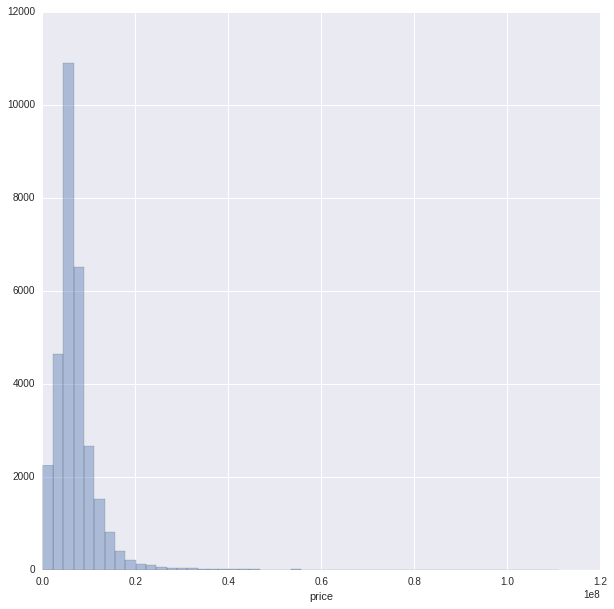

In [11]:
sns.distplot(train_df.price_doc.values, kde=None)
plt.xlabel('price')


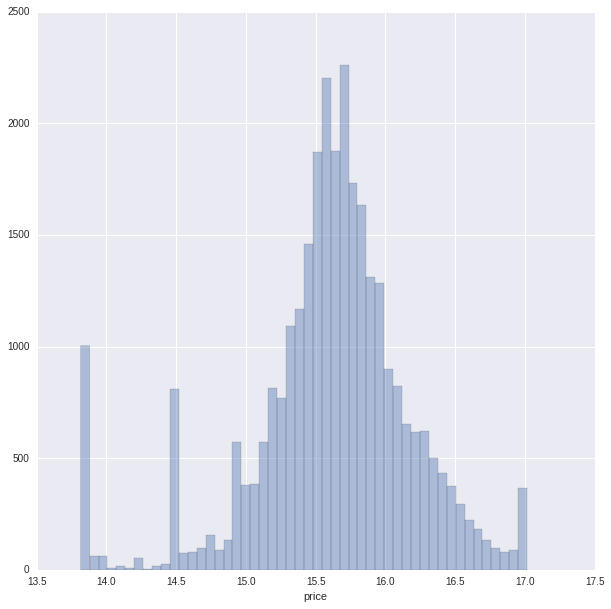

In [12]:
ulimit = np.percentile(train_df.price_doc.values, 99)
llimit = np.percentile(train_df.price_doc.values, 1)
train_df.loc[train_df['price_doc'] >ulimit, 'price_doc'] = ulimit
train_df.loc[train_df['price_doc'] <llimit, 'price_doc'] = llimit

sns.distplot(np.log(train_df.price_doc.values),  bins=50,kde=None)
plt.xlabel('price')

train_df['price_doc_log'] = np.log1p(train_df['price_doc'])

In [13]:
print(train_df['price_doc'].value_counts().head(10))

train_df['label_value'] = 0
train_df.loc[train_df['price_doc'] == 1000000, 'label_value'] = 1
train_df.loc[train_df['price_doc'] == 2000000, 'label_value'] = 2


1000000.0     980
2000000.0     757
6000000.0     372
3000000.0     332
6500000.0     330
7000000.0     319
5500000.0     309
24532075.4    305
6300000.0     295
5000000.0     294
Name: price_doc, dtype: int64


In [15]:
clfdata_X = train_df.drop(['id','timestamp','label_value','price_doc_log','price_doc'],axis=1)
clfdata_y = train_df['label_value']

clfX_train, clfX_test, clfY_train, clfY_test = train_test_split(clfdata_X, clfdata_y, test_size=0.30,random_state=21)

GBclf= GradientBoostingClassifier(max_depth=4,min_samples_leaf=2)


In [17]:
GBclf.fit(clfX_train,clfY_train)
GBclf.score(clfX_test,clfY_test)


0.94060380660686937

/home/xinlin/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


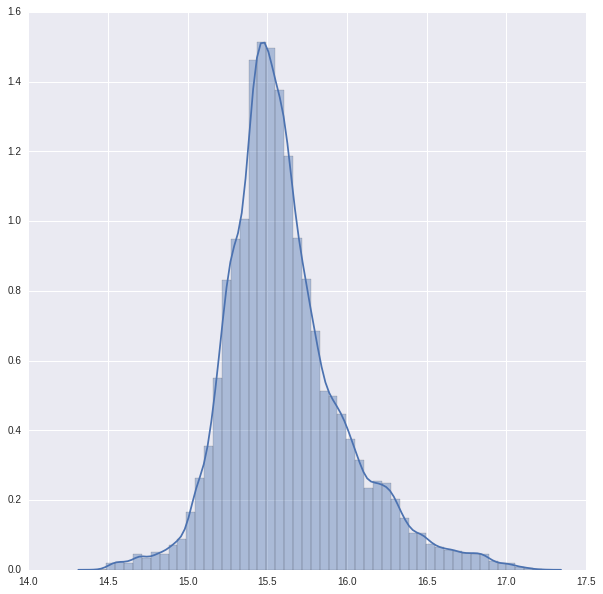

In [19]:
data_X = train_df.drop(["id","timestamp","price_doc","price_doc_log",'label_value'],axis=1)
data_y = train_df['price_doc_log']


GBmodel = GradientBoostingRegressor(min_samples_leaf= 4, learning_rate= 0.1, max_depth= 4)
GBmodel.fit(data_X,data_y)

sns.distplot(GBmodel.predict(data_X))

In [25]:
predict = GBmodel.predict(test_df.drop(["id", "timestamp"],axis=1))
lab = GBclf.predict(test_df.drop(['id','timestamp'],axis=1))
output = pd.DataFrame({'id': id_test, 'price_doc': np.expm1(predict)})
output['label'] = lab

output.loc[output['label'] == 1, 'price_doc'] = 1000000
output.loc[output['label'] == 2, 'price_doc'] = 2000000
output = output.drop(['label'],axis=1)

output.to_csv('170530_GBRT_classify_xgb.csv', index=False)
#print(output.loc[output['label']==1].shape)
#print(output.loc[output['label']==2].shape)